# Quantify how often clusters occurs across distant parts of the primary sequence

In [1]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys
import os

sys.path.append('../../')
from global_variables import SUBDIR, RUN, WORKSPACE

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Get genes detected by O3D
canonical_metadata = pd.read_table(f"{WORKSPACE}/nobackup/scratch/oncodrive3d/datasets_240506/seq_for_mut_prob.tsv")
canonical_metadata = canonical_metadata[["Gene", "Uniprot_ID"]].drop_duplicates().reset_index(drop=True)

genetable = pd.read_table(f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/o3d_paper/notebooks/0.genetables/results/{SUBDIR}/{RUN}.genetable.tsv")
genetable = genetable[["Gene", "CGC", "Fish", "o3d_qval"]]
genetable = genetable[genetable["o3d_qval"] < 0.01].reset_index(drop=True)
genetable = genetable[["Gene", "CGC"]].drop_duplicates()
genetable = genetable.merge(canonical_metadata, on="Gene", how="left")
genetable

,Gene,CGC,Uniprot_ID
0,PIK3CA,1,P42336
1,RXRA,0,P19793
2,FGFR3,1,P22607
3,FBXW7,1,Q969H0
4,TP53,1,P04637
...,...,...,...
268,CNBD1,1,Q8NA66
269,CDH1,1,P12830
270,TRIM49C,0,P0CI26
271,SPTA1,0,P02549


## Check at cluster level

In [3]:
def get_all_o3d_res_result(cohort_df, o3d_output_dir):

    lst_df = []

    for cohort in cohort_df["COHORT"].values:
        cohort = "TCGA_WXS_SOFT_TISSUE" if cohort == "TCGA_WXS_SARC" else cohort
        path_csv = f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_pos.csv"
        if os.path.exists(path_csv):
            df_o3d = pd.read_csv(path_csv, low_memory=False)
            cols = ["Cohort", "Gene", "Pos", "Mut_in_gene", "Score", "Score_obs_sim", "pval", "Rank", "Res_in_cl", 'C', 'C_ext']
            df_o3d = df_o3d[cols].dropna(subset=["pval"]).reset_index(drop=True)
            #df_o3d = df_o3d.reset_index().rename(columns={"index": "Rank"})
            df_o3d.pval = df_o3d.pval.replace(0, 0.00001)
            lst_df.append(df_o3d)
        else:
            print(f"Path doesn't exist: {path_csv}")
            
    df = pd.concat(lst_df)
    df = df.sort_values(["Cohort", "Gene", "Pos"], ascending=[False, True, True]).reset_index(drop=True)

    return df


def get_all_o3d_gene_result(cohort_df, o3d_output_dir):

    lst_df = []
    for cohort in cohort_df["COHORT"].values:
        cohort = "TCGA_WXS_SOFT_TISSUE" if cohort == "TCGA_WXS_SARC" else cohort
        path_csv = f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_genes.csv"
        if os.path.exists(path_csv):
            df_o3d = pd.read_csv(path_csv, low_memory=False)
            df_o3d = df_o3d[["Gene", "Uniprot_ID", "Cohort", "pval", "qval", "C_pos", "Score_obs_sim_top_vol", "Mut_in_top_vol", "Mut_in_gene"]].dropna(subset=["pval"]).reset_index(drop=True)
            df_o3d.pval = df_o3d.pval.replace(0, 0.00001)
            lst_df.append(df_o3d)
        else:
            print(f"Path doesn't exist: {path_csv}")
            
    df = pd.concat(lst_df)
    df = df.sort_values(["Cohort", "pval"], ascending=[False, True])

    return df.reset_index(drop=True)


def get_cgc_action(gene_action):

    if pd.isnull(gene_action):
        return "Ambiguous"
        
    gene_action = [action.strip() for action in gene_action.split(",")]

    if len(gene_action) == 1:
        if gene_action[0] == "oncogene":
            action = "Oncogene"
        elif gene_action[0] == "TSG":
            action = "Tumour suppressor"
        else:
            action = "Ambiguous"
        
    else:
        if "oncogene" in gene_action and "TSG" in gene_action:
            action = "Ambiguous"
        elif "oncogene" in gene_action:
            action = "Oncogene"
        elif "TSG" in gene_action:
            action = "Tumour suppressor"
        else:
            action = "Ambiguous"
    
    return action


def load_cmap(path, uni_id, f):

    cmap = np.load(f"{path}/{uni_id}-F{f}.npy")
    return (cmap > 0.5).astype(int)


def get_contact(cmap, x):
    return np.where(cmap[x] == 1)[0]


def get_non_contiguous_contacts(df, cutoff=1):
    
    return df['Contacts'].apply(lambda x: bool(np.any(np.diff(x) > cutoff)))


def get_max_contact_gap(df):

    return df['Contacts'].apply(
        lambda x: int(np.max(np.diff(x))) if len(x) > 1 else 0
    )


In [4]:
datasets = f"/{WORKSPACE}/projects/clustering_3d/o3d_analysys/datasets/"
input_path = f"{datasets}/input/cancer_202404"
cohort_df = pd.read_csv(f"{input_path}/cohorts.tsv", sep="\t")
cohort_df = cohort_df[~cohort_df.COHORT.str.startswith("ICGC")].reset_index(drop=True)
o3d_output_dir = f"{datasets}/output/cancer_202404/o3d_output/{SUBDIR}/{RUN}"

df_genes = get_all_o3d_gene_result(cohort_df, o3d_output_dir)
df_res = get_all_o3d_res_result(cohort_df, o3d_output_dir)
df_res

Path doesn't exist: //data/bbg/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv
Path doesn't exist: //data/bbg/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_pos.csv


,Cohort,Gene,Pos,Mut_in_gene,Score,Score_obs_sim,pval,Rank,Res_in_cl,C,C_ext
0,TCGA_WXS_WDTC,ABHD4,106,3,0.519823,0.991012,0.377,1,NaN,0,NaN
1,TCGA_WXS_WDTC,ABHD4,236,3,0.228704,0.463615,1.0,2,NaN,0,NaN
2,TCGA_WXS_WDTC,ABHD4,245,3,0.531449,0.931628,0.4611,0,NaN,0,NaN
3,TCGA_WXS_WDTC,ADPGK,495,2,1.0,1.437695,0.1367,0,NaN,0,NaN
4,TCGA_WXS_WDTC,AKT1,17,5,0.4821,1.433858,0.0754,0,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
616645,CBIOP_WGS_PRAD_EURUROL_2017,SPOP,133,11,0.381369,2.851625,0.00001,3,5.0,1,0.0
616646,CBIOP_WGS_PRAD_EURUROL_2017,SUN5,334,2,1.0,1.48961,0.1163,0,NaN,0,NaN
616647,CBIOP_WGS_PRAD_EURUROL_2017,TFAP4,289,2,1.0,1.703566,0.058,0,NaN,0,NaN
616648,CBIOP_WGS_PRAD_EURUROL_2017,TNKS2,341,2,1.0,1.716158,0.0497,0,NaN,0,NaN


In [5]:
cgc_df = pd.read_csv(f"{datasets}input/cancer_202404/CGC_list_v99.tsv", sep = "\t")
cgc_df = cgc_df[["Gene Symbol", "Role in Cancer"]].rename(columns={
    "Gene Symbol" : "Gene", 
    "Role in Cancer" : "Gene_action"})
cgc_df.Gene_action = cgc_df.Gene_action.apply(lambda x: get_cgc_action(x))
cgc_df = cgc_df.assign(Gene=cgc_df['Gene'].str.split(','))
cgc_df = cgc_df.explode('Gene')
cgc_df['Gene'] = cgc_df['Gene'].str.strip()
cgc_df.loc[cgc_df["Gene"] == "TP53", "Gene_action"] = "Tumour suppressor"
cgc_df

,Gene,Gene_action
0,A1CF,Oncogene
1,ABI1,Tumour suppressor
2,ABL1,Oncogene
3,ABL2,Oncogene
4,ACKR3,Oncogene
...,...,...
738,ZNF429,Ambiguous
739,ZNF479,Ambiguous
740,ZNF521,Oncogene
741,ZNRF3,Tumour suppressor


In [6]:
genes_hit = df_genes[df_genes["qval"] < 0.01].reset_index(drop=True)
genes_hit['Cohort_Gene'] = genes_hit['Cohort'] + '|' + genes_hit['Gene']
genes_hit

,Gene,Uniprot_ID,Cohort,pval,qval,C_pos,Score_obs_sim_top_vol,Mut_in_top_vol,Mut_in_gene,Cohort_Gene
0,BRAF,P15056,TCGA_WXS_WDTC,0.00001,0.0,[601 600],179.618281,287.0,287,TCGA_WXS_WDTC|BRAF
1,NRAS,P01111,TCGA_WXS_WDTC,0.00001,0.0,[61],15.507143,39.0,39,TCGA_WXS_WDTC|NRAS
2,HRAS,P01112,TCGA_WXS_WDTC,0.00001,0.0,[61],7.066159,17.0,17,TCGA_WXS_WDTC|HRAS
3,GNAQ,A0A024R240,TCGA_WXS_UM,0.00001,0.0,[209 48],18.591696,38.0,40,TCGA_WXS_UM|GNAQ
4,GNA11,P29992,TCGA_WXS_UM,0.00001,0.0,[209],14.753669,34.0,36,TCGA_WXS_UM|GNA11
...,...,...,...,...,...,...,...,...,...,...
614,G3BP1,Q13283,CBIOP_WXS_ANGS_TREATED_2020,0.00001,0.0,[4 5],3.180288,4.0,4,CBIOP_WXS_ANGS_TREATED_2020|G3BP1
615,RETSAT,Q6NUM9,CBIOP_WXS_ACY_2019,0.00001,0.0,[533 536],3.745953,6.0,6,CBIOP_WXS_ACY_2019|RETSAT
616,NOTCH2,Q04721,CBIOP_WXS_ACY_2019,0.00001,0.0,[3],3.656038,4.0,4,CBIOP_WXS_ACY_2019|NOTCH2
617,TP53,K7PPA8,CBIOP_WGS_STAD_ONCOSG_2018,0.00001,0.0,[239 242 245 236 248 273 175 195 237 179 132 2...,7.151944,26.0,47,CBIOP_WGS_STAD_ONCOSG_2018|TP53


In [7]:
cmaps = f"{WORKSPACE}/nobackup/scratch/oncodrive3d/datasets_mane_240506/prob_cmaps"
seq_df = pd.read_table(f"{WORKSPACE}/nobackup/scratch/oncodrive3d/datasets_mane_240506/seq_for_mut_prob.tsv")
seq_df = seq_df[seq_df.Gene.isin(genes_hit.Gene)].reset_index(drop=True)[["Gene", "Uniprot_ID", "F"]]
seq_df

,Gene,Uniprot_ID,F
0,ZNF93,P35789,1
1,ZNF91,Q05481,1
2,ZNF880,Q6PDB4,1
3,ZNF83,P51522,1
4,ZNF804A,Q7Z570,1
...,...,...,...
268,AHNAK,Q09666,24M
269,AGAP6,Q5VW22,1
270,ADH4,P08319,1
271,ADGRV1,Q8WXG9,26M


In [8]:
df_res['Cohort_Gene'] = df_res['Cohort'] + '|' + df_res['Gene']
df_res = df_res[df_res.Cohort_Gene.isin(genes_hit.Cohort_Gene)]
df_res = df_res[df_res["C"] == 1].reset_index(drop=True)
df_res['Cohort_Gene'] = df_res['Cohort_Gene'] + '|' + df_res['Pos'].astype(str)
df_res

,Cohort,Gene,Pos,Mut_in_gene,Score,Score_obs_sim,pval,Rank,Res_in_cl,C,C_ext,Cohort_Gene
0,TCGA_WXS_WDTC,BRAF,600,287,1.0,179.618281,0.00001,1,2.0,1,0.0,TCGA_WXS_WDTC|BRAF|600
1,TCGA_WXS_WDTC,BRAF,601,287,1.0,159.730994,0.00001,0,2.0,1,0.0,TCGA_WXS_WDTC|BRAF|601
2,TCGA_WXS_WDTC,HRAS,61,17,1.0,7.066159,0.00001,0,1.0,1,0.0,TCGA_WXS_WDTC|HRAS|61
3,TCGA_WXS_WDTC,NRAS,61,39,1.0,15.507143,0.00001,0,1.0,1,0.0,TCGA_WXS_WDTC|NRAS|61
4,TCGA_WXS_UM,GNA11,209,36,0.880534,14.753669,0.00001,0,1.0,1,0.0,TCGA_WXS_UM|GNA11|209
...,...,...,...,...,...,...,...,...,...,...,...,...
4111,CBIOP_WGS_PRAD_EURUROL_2017,SPOP,87,11,0.840076,5.499366,0.00001,1,5.0,1,0.0,CBIOP_WGS_PRAD_EURUROL_2017|SPOP|87
4112,CBIOP_WGS_PRAD_EURUROL_2017,SPOP,102,11,0.448503,3.155023,0.00001,2,5.0,1,0.0,CBIOP_WGS_PRAD_EURUROL_2017|SPOP|102
4113,CBIOP_WGS_PRAD_EURUROL_2017,SPOP,125,11,0.12842,1.013015,0.3533,4,5.0,1,1.0,CBIOP_WGS_PRAD_EURUROL_2017|SPOP|125
4114,CBIOP_WGS_PRAD_EURUROL_2017,SPOP,131,11,1.0,5.947184,0.00001,0,5.0,1,0.0,CBIOP_WGS_PRAD_EURUROL_2017|SPOP|131


In [9]:
# df_res = pd.read_csv("data/df_res.csv")
# genes_hit = pd.read_csv("data/genes_hit.csv")

In [10]:
# df_res.to_csv("data/df_res.csv", index=False)
# genes_hit.to_csv("data/genes_hit.csv", index=False)

In [11]:
# df_res_sorted = df_res.sort_values(["Gene", "Pos"]).reset_index(drop=True)
# clusters = df_res_sorted["Gene"] + "|" + df_res_sorted["Pos"].astype(str)
# clusters = clusters.unique()
# clusters_dict = {}

# current_gene = ""
# for cluster in tqdm(clusters):
#     gene, pos = cluster.split("|")
#     pos = int(pos)
#     _, uni_id, f = seq_df[seq_df["Gene"] == gene].values[0]
#     if gene != current_gene:
#         clusters_dict[gene] = {}
#         cmap = load_cmap(cmaps, uni_id, f)
#         current_gene = gene
#     clusters_dict[gene][pos] = get_contact(cmap, pos-1)

In [12]:
# For each cluster (Cohort | Gene | Pos) get the mutated residues in contact in that cohort
# Consider only cluster (C = 1, i.e., qval < 0.01 or providing mut to a res with qval < 0.01) from detected genes

df_res = df_res.sort_values(["Gene", "Cohort"]).reset_index(drop=True)

clusters_cohort_dict = {}
current_gene = ""
for group, df in tqdm(df_res.groupby(["Gene", 'Cohort'])):
    gene, cohort = group
    all_pos = df.Pos.values
    
    _, uni_id, f = seq_df[seq_df["Gene"] == gene].values[0]
    if gene != current_gene:
        cmap = load_cmap(cmaps, uni_id, f)
        current_gene = gene
    
    # Get contacts among the mutated positions
    for row in df.itertuples():
        cluster = row.Cohort_Gene
        contacts = [p for p in get_contact(cmap, row.Pos-1) if p in all_pos] 
        clusters_cohort_dict[cluster] = contacts
        
df_res["Contacts"] = df_res.Cohort_Gene.map(clusters_cohort_dict)
df_res = df_res.drop(columns=["Cohort_Gene"])
df_res["Max_distance"] = get_max_contact_gap(df_res)
df_res = df_res.merge(cgc_df, on="Gene", how="left")
df_res

100%|██████████| 619/619 [00:01<00:00, 389.31it/s]


,Cohort,Gene,Pos,Mut_in_gene,Score,Score_obs_sim,pval,Rank,Res_in_cl,C,C_ext,Contacts,Max_distance,Gene_action
0,PEDCBIOP_WXS_HGG_PRY,ACVR1,328,12,0.445998,2.993457,0.00001,0,1.0,1,0.0,[328],0,Oncogene
1,PCAWG_WGS_LIVER_HCC,ADGRV1,4500,24,0.164718,3.056457,0.00001,1,4.0,1,0.0,"[4500, 4501]",1,NaN
2,PCAWG_WGS_LIVER_HCC,ADGRV1,4501,24,0.164454,3.15831,0.00001,2,4.0,1,0.0,"[4500, 4501]",1,NaN
3,PCAWG_WGS_LIVER_HCC,ADGRV1,4503,24,0.197258,3.503474,0.00001,0,4.0,1,0.0,"[4500, 4501, 4503, 4504]",2,NaN
4,PCAWG_WGS_LIVER_HCC,ADGRV1,4504,24,0.132344,2.600894,0.00001,3,4.0,1,0.0,"[4501, 4503, 4504]",2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4111,CBIOP_WXS_BLCA_BGI,ZNF83,290,25,0.796957,12.892111,0.00001,1,2.0,1,0.0,"[290, 293]",3,NaN
4112,CBIOP_WXS_BLCA_BGI,ZNF83,293,25,0.802778,11.857008,0.00001,0,2.0,1,0.0,"[290, 293]",3,NaN
4113,CBIOP_WXS_LUAD_ONCOSG_2020,ZNF880,406,5,1.0,3.60575,0.00001,0,1.0,1,0.0,[406],0,NaN
4114,OTHER_WXS_NPC_NATCOM2017,ZNF91,353,20,0.330115,4.545938,0.00001,0,1.0,1,0.0,[353],0,NaN


In [18]:
df_distance = df_res[["Gene", "Gene_action", "Pos", "Contacts", "Max_distance"]]
df_distance["Gene_action"] = df_distance.Gene_action.fillna("Not annotated")
df_distance = df_distance[df_distance["Gene_action"] != "Ambiguous"].reset_index(drop=True)
df_distance

/tmp/ipykernel_1872905/2845391841.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_distance["Gene_action"] = df_distance.Gene_action.fillna("Not annotated")


,Gene,Gene_action,Pos,Contacts,Max_distance
0,ACVR1,Oncogene,328,[328],0
1,ADGRV1,Not annotated,4500,"[4500, 4501]",1
2,ADGRV1,Not annotated,4501,"[4500, 4501]",1
3,ADGRV1,Not annotated,4503,"[4500, 4501, 4503, 4504]",2
4,ADGRV1,Not annotated,4504,"[4501, 4503, 4504]",2
...,...,...,...,...,...
3893,ZNF83,Not annotated,290,"[290, 293]",3
3894,ZNF83,Not annotated,293,"[290, 293]",3
3895,ZNF880,Not annotated,406,[406],0
3896,ZNF91,Not annotated,353,[353],0


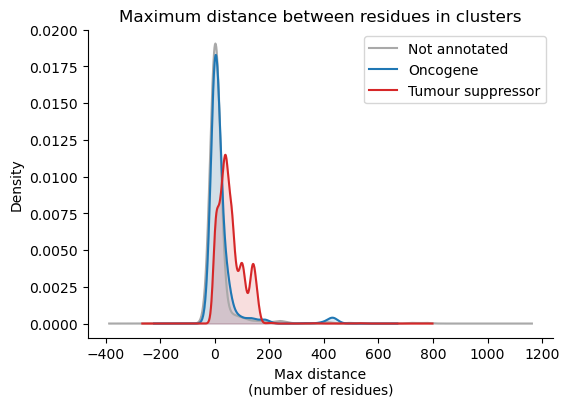

In [15]:
import pandas as pd

palette = {'Oncogene': 'C10', 'Tumour suppressor': 'C3', "Ambiguous" : "#ff6afe", 'Not annotated': 'darkgray'}

# Plot density distributions grouped by Gene_action
fig, ax = plt.subplots(figsize=(6, 4))
for name, group in df_distance.groupby('Gene_action'):
    distances = group['Max_distance']
    color = palette.get(name, 'black')
    if len(distances) > 1:
        distances.plot.kde(ax=ax, label=name, color=color)
        line = ax.get_lines()[-1]
        x, y = line.get_xdata(), line.get_ydata()
        ax.fill_between(x, y, color=color, alpha=0.15)
    else:
        ax.axvline(distances.iloc[0], linestyle='--', label=f"{name} (single)")

ax.set_title('Maximum distance between residues in clusters')
ax.set_xlabel('Max distance\n(number of residues)')
ax.set_ylabel('Density')
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

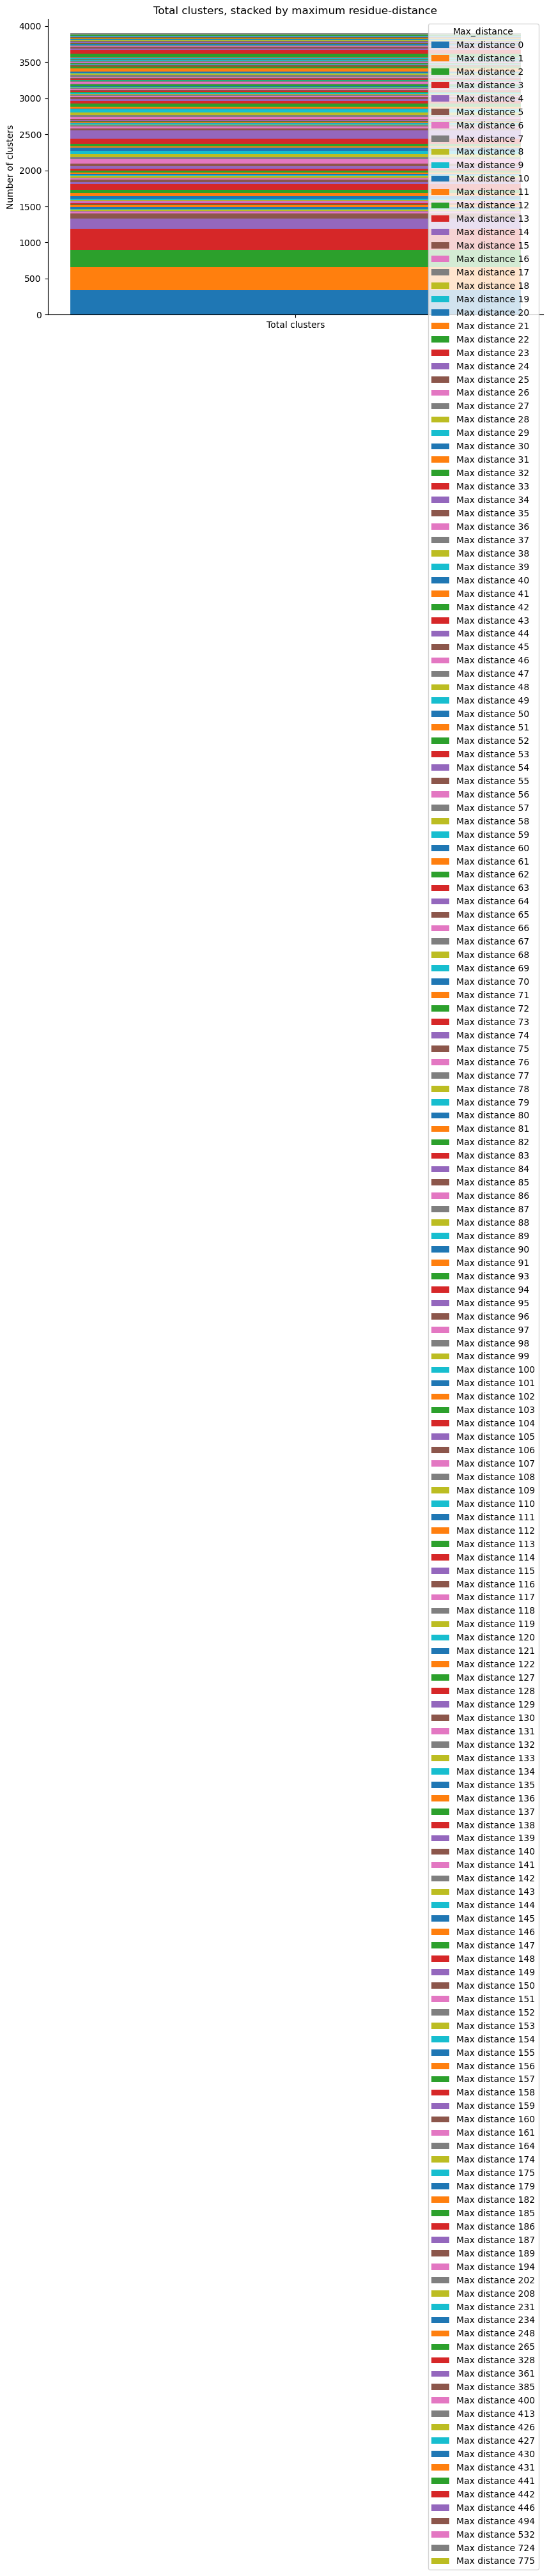

In [16]:
import matplotlib.pyplot as plt

# 1. Count clusters by max_distance, in ascending order
counts = df_distance['Max_distance'].value_counts().sort_index()

# 2. Build a single “Total clusters” bar, stacking each distance
fig, ax = plt.subplots(figsize=(10, 6))
bottom = 0
for dist, cnt in counts.items():
    ax.bar(
        'Total clusters',  # one bar
        cnt, 
        bottom=bottom, 
        label=f'Max distance {dist}'
    )
    bottom += cnt

# 3. Tidy up
ax.set_ylabel('Number of clusters')
ax.set_title('Total clusters, stacked by maximum residue‐distance')
ax.legend(title='Max_distance')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()


/tmp/ipykernel_1872905/3876902127.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


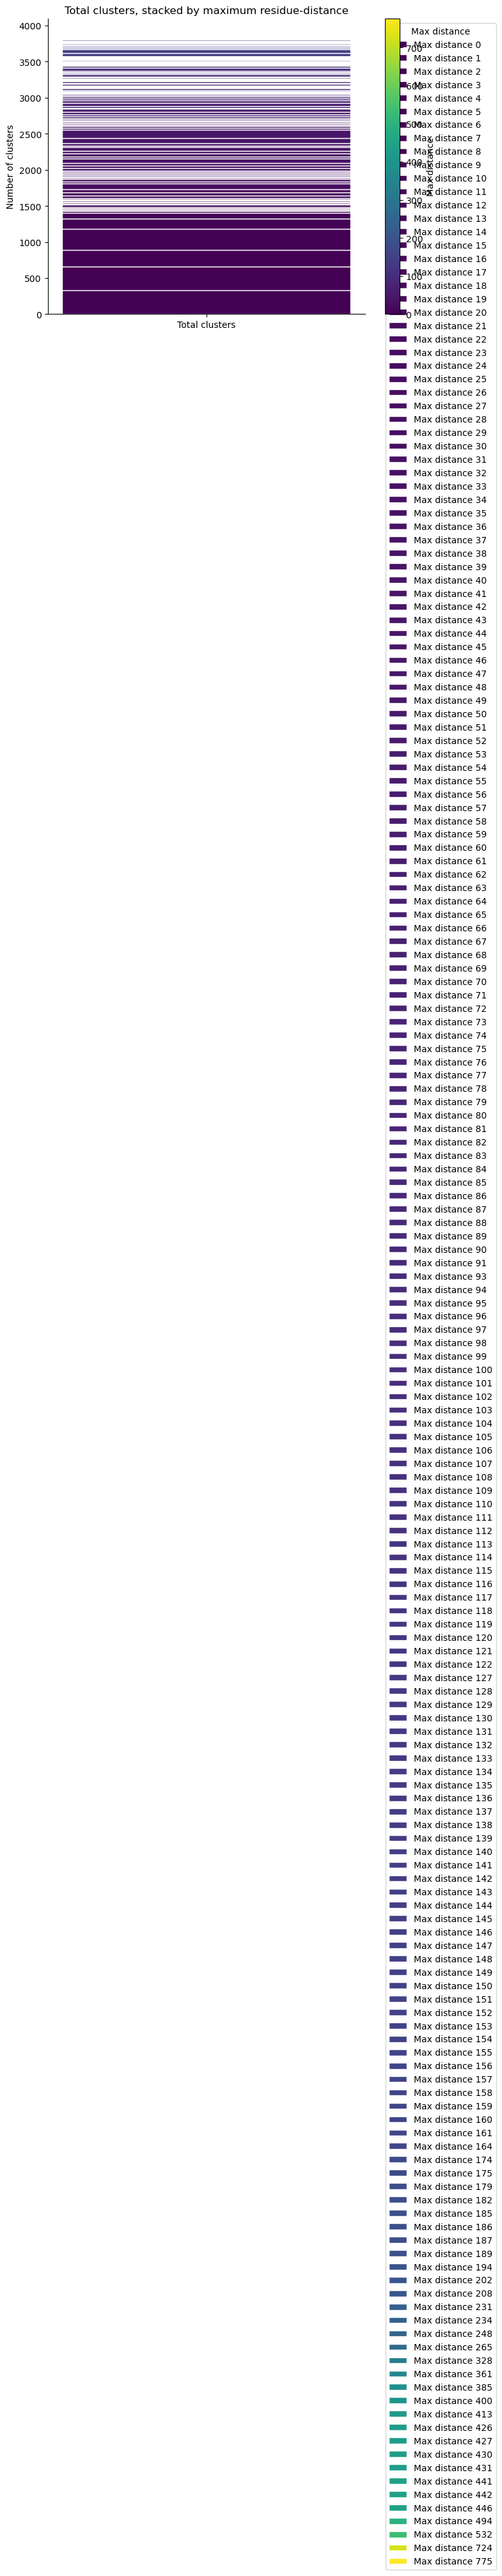

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Count clusters by max_distance
counts = df_distance['Max_distance'].value_counts().sort_index()

# Continuous colormap and normalizer
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=counts.index.min(), vmax=counts.index.max())

# Plot stacked bar
fig, ax = plt.subplots(figsize=(8, 6))
bottom = 0
for dist, cnt in counts.items():
    color = cmap(norm(dist))
    ax.bar(
        'Total clusters',
        cnt,
        bottom=bottom,
        color=color,
        edgecolor='white',
        label=f'Max distance {dist}'
    )
    bottom += cnt

# Add colorbar
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Max distance')

# Tidy up
ax.set_ylabel('Number of clusters')
ax.set_title('Total clusters, stacked by maximum residue-distance')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(title='Max distance', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [27]:
df_distance = df_res[["Gene", "Gene_action", "Pos", "Contacts", "Max_distance"]]
df_distance["Gene_action"] = df_distance.Gene_action.fillna("Not annotated")
df_distance = df_distance[df_distance["Gene_action"] != "Ambiguous"].reset_index(drop=True)
df_distance

/tmp/ipykernel_1872905/2845391841.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_distance["Gene_action"] = df_distance.Gene_action.fillna("Not annotated")


,Gene,Gene_action,Pos,Contacts,Max_distance
0,ACVR1,Oncogene,328,[328],0
1,ADGRV1,Not annotated,4500,"[4500, 4501]",1
2,ADGRV1,Not annotated,4501,"[4500, 4501]",1
3,ADGRV1,Not annotated,4503,"[4500, 4501, 4503, 4504]",2
4,ADGRV1,Not annotated,4504,"[4501, 4503, 4504]",2
...,...,...,...,...,...
3893,ZNF83,Not annotated,290,"[290, 293]",3
3894,ZNF83,Not annotated,293,"[290, 293]",3
3895,ZNF880,Not annotated,406,[406],0
3896,ZNF91,Not annotated,353,[353],0


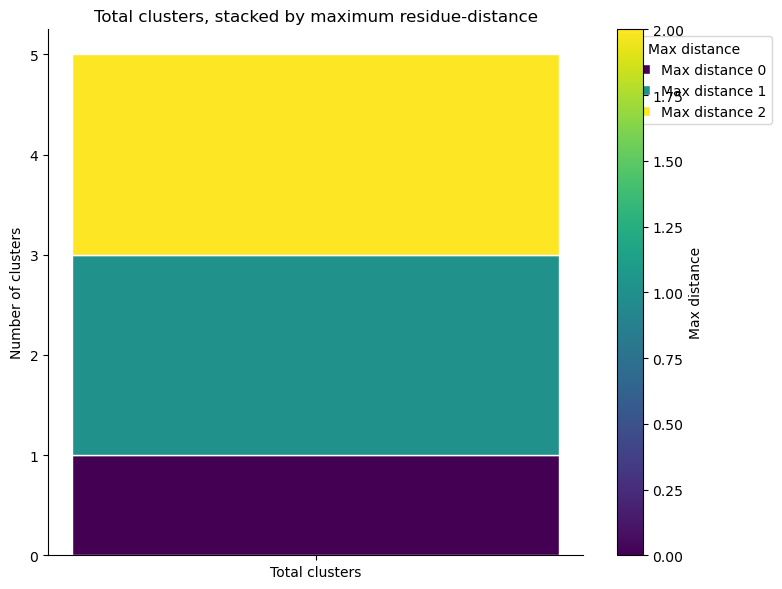

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace this snippet with your full df_distance DataFrame
df_distance = pd.DataFrame({'Max_distance': [0, 1, 1, 2, 2]})

# Count clusters by max_distance
counts = df_distance['Max_distance'].value_counts().sort_index()

# Continuous colormap and normalizer
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=counts.index.min(), vmax=counts.index.max())

# Plot stacked bar
fig, ax = plt.subplots(figsize=(8, 6))
bottom = 0
for dist, cnt in counts.items():
    color = cmap(norm(dist))
    ax.bar(
        'Total clusters',
        cnt,
        bottom=bottom,
        color=color,
        edgecolor='white',
        label=f'Max distance {dist}'
    )
    bottom += cnt

# Add colorbar
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Max distance')

# Tidy up
ax.set_ylabel('Number of clusters')
ax.set_title('Total clusters, stacked by maximum residue-distance')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(title='Max distance', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
